In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
from scipy import stats
import math
import statsmodels.api as sm
from IPython.display import display_html

In [2]:
def display_dfs(dfs, names=[]):
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {df.to_html(index=False)}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

In [3]:
df = pd.read_csv(os.path.join('d:\downloads', 'us events ad_revenue filtered 03.02-07.02.csv'))

In [33]:
df.head() 

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [34]:
df.event_json.iloc[0]

'{"ad_type":"banner","placement":"","view_index":1,"session_view_index":0,"cur_ticks":637795729492245130,"session_length":705.8807,"revenue":0.000510313,"ads_ltv":0.487876676518837,"ecpm_sma":0.511508107185364,"normalized_ecpm_sma":0.511508107185364,"value":0.000510313,"currency":"USD","ad_country_code":"US","network_name":"Google AdMob","ad_unit_id":"64c6b1114ea8c1cc","ad_network_placement":"ca-app-pub-7511632782617496/8825263691","creativeId":"CJ3XirfD5vUCFYPnKAUdG3MOYQ"}'

In [6]:
df.event_json = df.event_json.apply(json.loads)

In [7]:
for key in df.event_json.values[0].keys():
    df[key] = df['event_json'].apply(lambda x: x[key])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_json               860079 non-null  object 
 8   event_datetime           860079 non-null  object 
 9   event_timestamp          860079 non-null  int64  
 10  event_receive_datetime   860079 non-null  object 
 11  event_receive_timestamp  860079 non-null  int64  
 12  connection_type          860079 non-null  object 
 13  operator_name            841200 non-null  object 
 14  coun

In [8]:
df=df[['profile_id', 'os_version', 'event_datetime', 'city', 'ad_type','revenue',]]

In [39]:
df[df.revenue == 0]

,profile_id,os_version,event_datetime,city,ad_type,revenue
670440,JL7PaV98HXg,9,2022-02-02 07:25:22,Glastonbury,int,0.0


Так как всего одна запись с нулевой доходностью, удалим её как выброс. Это понадобится в дальнейшем для логарифмирования данных

In [9]:
df.drop(index=670440, inplace=True)

C:\Users\Ft1me\AppData\Local\Temp\ipykernel_47360\3697625530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=670440, inplace=True)


# Распределение средней доходности юзеров для каждого формата рекламы

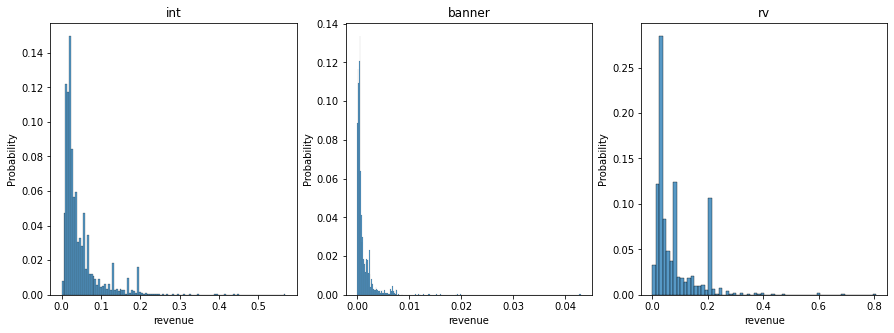

In [88]:
i=0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ad in set(df.ad_type.values):
    sns.histplot(df[df.ad_type == ad].groupby(by='profile_id').mean().revenue, stat='probability', ax=axes[i])
    axes[i].set_title(label=f'{ad}')
    i+=1

Так как распределение перекошено, прологарифмируем ось x

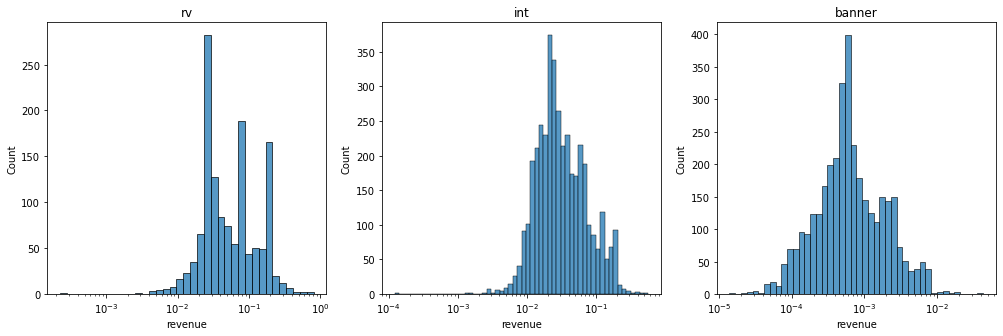

In [72]:
i=0
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ad in set(df.ad_type.values):
    sns.histplot(df[df.ad_type == ad].groupby(by='profile_id').mean().revenue, log_scale=True, ax=axes[i])
    axes[i].set_title(label=f'{ad}')
    i+=1

In [ ]:
Среднее значение для рекламы на баннере меньше, чем для других видов, что логично, так как баннер отрыт всегда и пользователи постоянно  

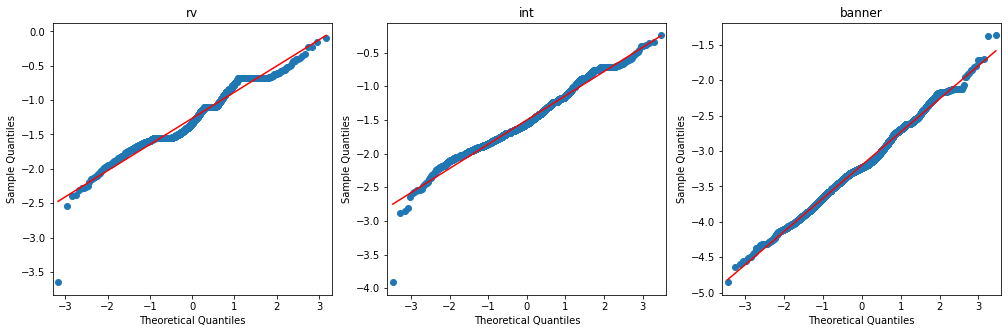

In [23]:
i=1
fig = plt.figure(figsize=(17, 5))

for ad in set(df.ad_type.values):
    ax = fig.add_subplot(1, 3, i)
    sm.qqplot(df[df.ad_type == ad].groupby(by='profile_id').mean().revenue.apply(math.log10), line='r', ax=ax)
    ax.set_title(label=f'{ad}')
    i+=1

Графики QQ-Plot неплохо аппроксимируются прямой, что говорит о линейной связи распределений с нормальным распределением

# Средняя доходность по городам для каждого формата рекламы

C:\Users\Ft1me\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='revenue'>

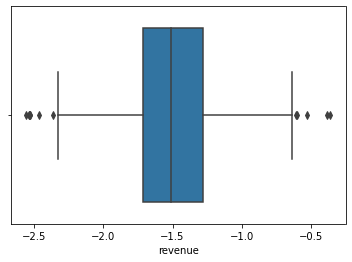

In [177]:
sns.boxplot(df[df.ad_type == 'int'].groupby(by='city').mean().revenue.apply(math.log10))

In [132]:
city_mean = dict()
for ad in set(df.ad_type.values):
    city_mean[ad] = df[df.ad_type == ad].groupby(by='city').mean().sort_values(['revenue'], ascending=False).reset_index()

In [136]:
display_dfs((city_mean[key].iloc[:10] for key in city_mean.keys()), city_mean.keys())

int banner rv 
 
 
 city 
 revenue 
 
 
 
 
 Madisonville 
 0.437040 
 
 
 La Crosse 
 0.415159 
 
 
 Rohnert Park 
 0.297600 
 
 
 Nashua 
 0.252556 
 
 
 Norwood 
 0.245529 
 
 
 Spirit Lake 
 0.229196 
 
 
 Rocky Mount 
 0.227191 
 
 
 Oxnard 
 0.221146 
 
 
 Lake Worth 
 0.219315 
 
 
 Fredericksburg 
 0.214480 
 
 
 
 
 
 city 
 revenue 
 
 
 
 
 La Crosse 
 0.019326 
 
 
 Mountain View 
 0.012750 
 
 
 Huron 
 0.007575 
 
 
 Lawrenceville 
 0.007519 
 
 
 Oxnard 
 0.007519 
 
 
 Colchester 
 0.007344 
 
 
 Corbin 
 0.007288 
 
 
 Clarks Summit 
 0.007266 
 
 
 Dobson 
 0.006988 
 
 
 Muncie 
 0.006929 
 
 
 
 
 
 city 
 revenue 
 
 
 
 
 East Peoria 
 0.808295 
 
 
 Norwood 
 0.597984 
 
 
 Idaho Falls 
 0.366840 
 
 
 Valparaiso 
 0.318750 
 
 
 Rocky Mount 
 0.290112 
 
 
 Hilliard 
 0.278537 
 
 
 Glen Burnie 
 0.276948 
 
 
 Mayfield 
 0.276442 
 
 
 El Paso 
 0.249244 
 
 
 Port Huron 
 0.245026

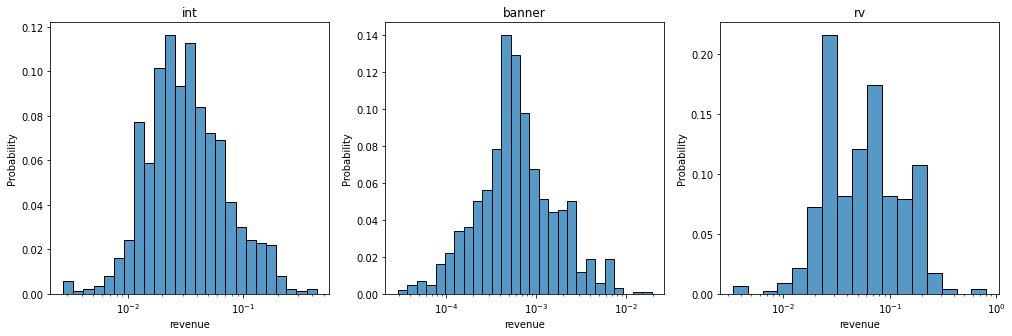

In [101]:
i=0
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ad in set(df.ad_type.values):
    sns.histplot(df[df.ad_type == ad].groupby(by='city').mean().revenue,log_scale=True, stat='probability', ax=axes[i])
    axes[i].set_title(label=f'{ad}')
    i+=1

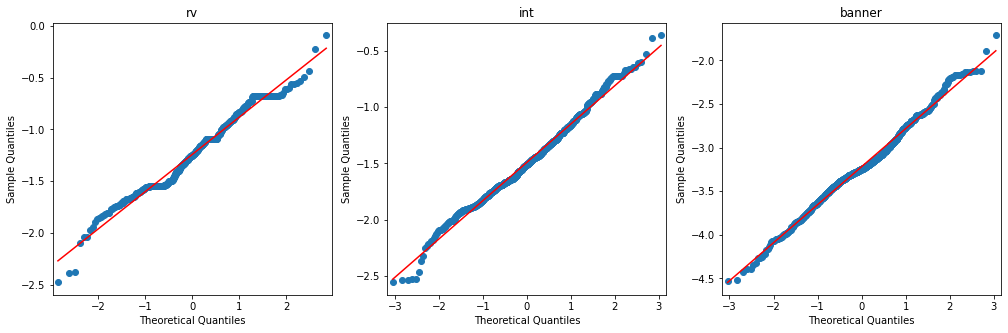

In [24]:
i=1
fig = plt.figure(figsize=(17, 5))

for ad in set(df.ad_type.values):
    ax = fig.add_subplot(1, 3, i)
    sm.qqplot(df[df.ad_type == ad].groupby(by='city').mean().revenue.apply(math.log10), line='r', ax=ax)
    ax.set_title(label=f'{ad}')
    i+=1

# Средняя доходность различных типов ОС для каждого формата рекламы

Text(0.5, 1.0, 'int')

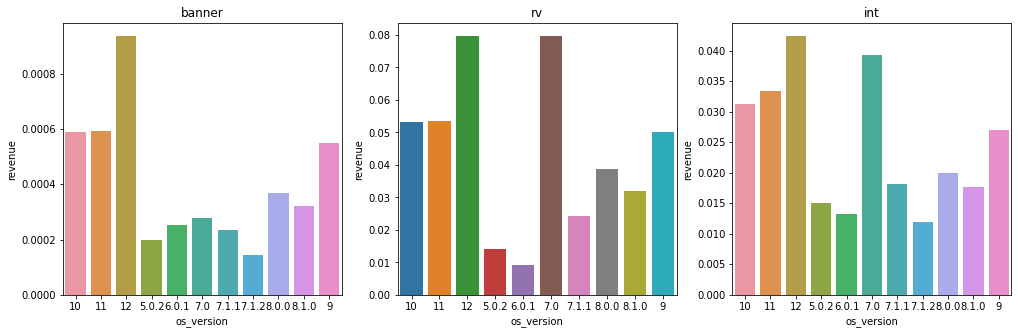

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.barplot(ax=axes[0], data = df[df.ad_type == 'banner'].groupby(by='os_version').mean().reset_index(), y='revenue', x='os_version')
axes[0].set_title('banner')

sns.barplot(ax=axes[1], data = df[df.ad_type == 'rv'].groupby(by='os_version').mean().reset_index(), y='revenue', x='os_version')
axes[1].set_title('rv')

sns.barplot(ax=axes[2], data = df[df.ad_type =='int'].groupby(by='os_version').mean().reset_index(), y='revenue', x='os_version')
axes[2].set_title('int')

# Суммарная доходность различных типов ОС для каждого формата рекламы

Text(0.5, 1.0, 'int')

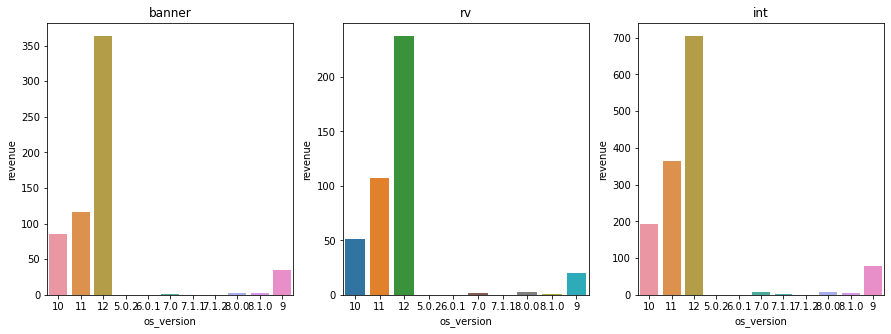

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(ax=axes[0], data = df[df.ad_type == 'banner'].groupby(by='os_version').sum().reset_index(), y='revenue', x='os_version')
axes[0].set_title('banner')

sns.barplot(ax=axes[1], data = df[df.ad_type == 'rv'].groupby(by='os_version').sum().reset_index(), y='revenue', x='os_version')
axes[1].set_title('rv')

sns.barplot(ax=axes[2], data = df[df.ad_type =='int'].groupby(by='os_version').sum().reset_index(), y='revenue', x='os_version')
axes[2].set_title('int')

Из графиков видно, что чем новее версия ОС, тем больше прибыль. Это может быть связано с тем, что пользователи более современных телефонов больше заинтересованы в играх на телефоне и, соответственно, проводят в них больше времени.

# Суммарная доходность по городам для различных форматов рекламы

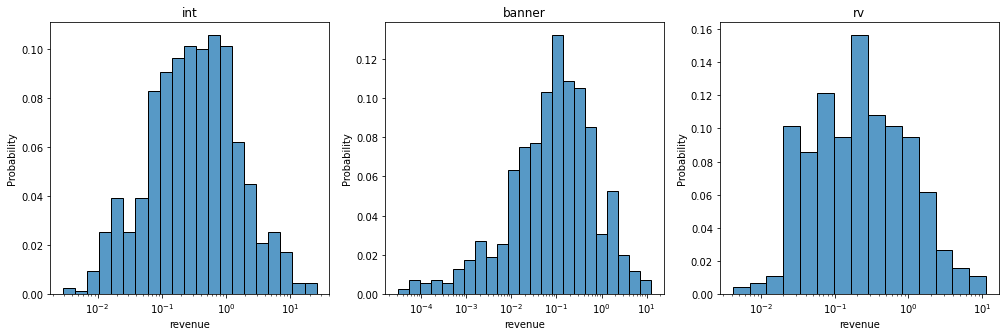

In [105]:
i=0
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ad in set(df.ad_type.values):
    sns.histplot(df[df.ad_type == ad].groupby(by='city').sum().revenue,log_scale=True, stat='probability', ax=axes[i])
    axes[i].set_title(label=f'{ad}')
    i+=1

Суммарная доходность 

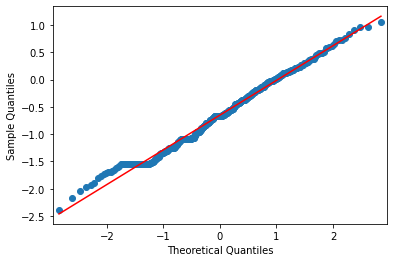

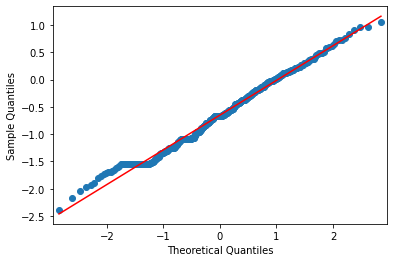

In [70]:
sm.qqplot(df[df.ad_type == 'rv'].groupby(by='city').sum().revenue.apply(math.log10), line='r')

In [90]:
df['hour'] = df.event_datetime.apply(lambda x: x.split(' ')[1].split(':')[0])

C:\Users\Ft1me\AppData\Local\Temp\ipykernel_47360\1750165252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.event_datetime.apply(lambda x: x.split(' ')[1].split(':')[0])


<AxesSubplot:xlabel='hour', ylabel='revenue'>

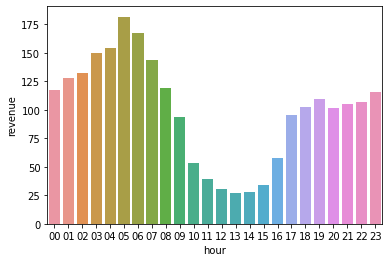

In [100]:
sns.barplot(data=df.groupby(by='hour').sum().reset_index(),y='revenue', x='hour')